In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from functools import partial

from math import nan

from CASutils import averaging_utils as avg
from CASutils import mapplot_utils as mymaps
from CASutils import colorbar_utils as cbars

import cartopy.crs as ccrs

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/ocn_wgts/LANDFRAC_LENS2.nc")

In [4]:
# to take the FSNO or ICEFRAC average only over land or ocean grid points.
notlandfrac = xr.where(np.isnan(landfrac.landfrac) | (landfrac.landfrac < 0.5), 1, nan)
landregions = xr.where(~np.isnan(landfrac.landfrac) | (landfrac.landfrac > 0.5), 1, nan) 

In [5]:
# pre-processor to ensure all lon and lat coordinates are the same.  Also adding flexibility for reading in seasonal data
# Taking the ensemble mean
def preprocessor(ds):
    ds['lon'] = landfrac.lon ; ds['lat'] = landfrac.lat
    ds = ds.mean('M')
    ds['time'] = ds.time.dt.year
    ds = ds.rename({'time':'year'})
    ds = ds.sel(year=slice(1920,2050))
    return ds

In [6]:
seas='djf' ; var = ['TREFHT','FSNS','FSDS','ICEFRAC']

### Read in the CESM1 data

In [7]:
baselens1='/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1/'
lens1 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens1+'LENS1_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens1.append(dat)
lens1 = xr.merge(lens1)
fsus = lens1.FSDS - lens1.FSNS
fsus = fsus.rename('FSUS')
lens1 = xr.merge([lens1, fsus])

In [8]:
basexaer1="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1-SF/"
xaer1 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer1+'XAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer1.append(dat)
xaer1 = xr.merge(xaer1)
fsus = xaer1.FSDS - xaer1.FSNS
fsus = fsus.rename('FSUS')
xaer1 = xr.merge([xaer1, fsus])

In [9]:
baseaaer1="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM1-AAER/"
aer1 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaaer1+'AAER_'+ivar+"_"+seas+".nc", preprocess=partial(preprocessor))
    aer1.append(dat)
aer1 = xr.merge(aer1)
fsus = aer1.FSDS - aer1.FSNS
fsus = fsus.rename('FSUS')
aer1 = xr.merge([aer1, fsus])

### Subtract out the base period

In [10]:
lens1base = lens1.sel(year=slice(1920,1940)).mean('year')
aer1base = aer1.sel(year=slice(1920,1940)).mean('year')
xaer1base = xaer1.sel(year=slice(1920,1940)).mean('year')

In [11]:
xaer1_1960to1980 = xaer1.sel(year=slice(1960,1980)).mean('year').load() # for plotting sea ice edge

In [12]:
lens1 = lens1 - lens1base
aer1 = aer1 - aer1base
xaer1 = xaer1 - xaer1base

In [13]:
aer1xway = lens1 - xaer1

### Average over the 50S-90S region

In [14]:
aer1['ICEFRAC'] = notlandfrac*aer1.ICEFRAC
aer1xway['ICEFRAC'] = notlandfrac*aer1xway.ICEFRAC

aer1_nh = avg.cosweightlonlat(aer1, 0, 360, -90, -50)
aer1xway_nh = avg.cosweightlonlat(aer1xway, 0, 360, -90, -50)

### Calculate the 21 year running mean

In [15]:
# 21 year running means
def calc21ymean(dat):
    datm = dat.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
    return datm

In [16]:
aer1_nh_21y = calc21ymean(aer1_nh).load()
aer1xway_nh_21y = calc21ymean(aer1xway_nh).load()

In [17]:
cesm1boot = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS13/CESM1_bootstrap.nc")
cesm1bootfsus = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS13/CESM1_bootstrap_Albedo_FSUS.nc")

### Plot the plot

In [18]:
aer1_1960to1980 = aer1.sel(year=slice(1960,1980)).mean('year').load()
aer1xway_1960to1980 = aer1xway.sel(year=slice(1960,1980)).mean('year').load()

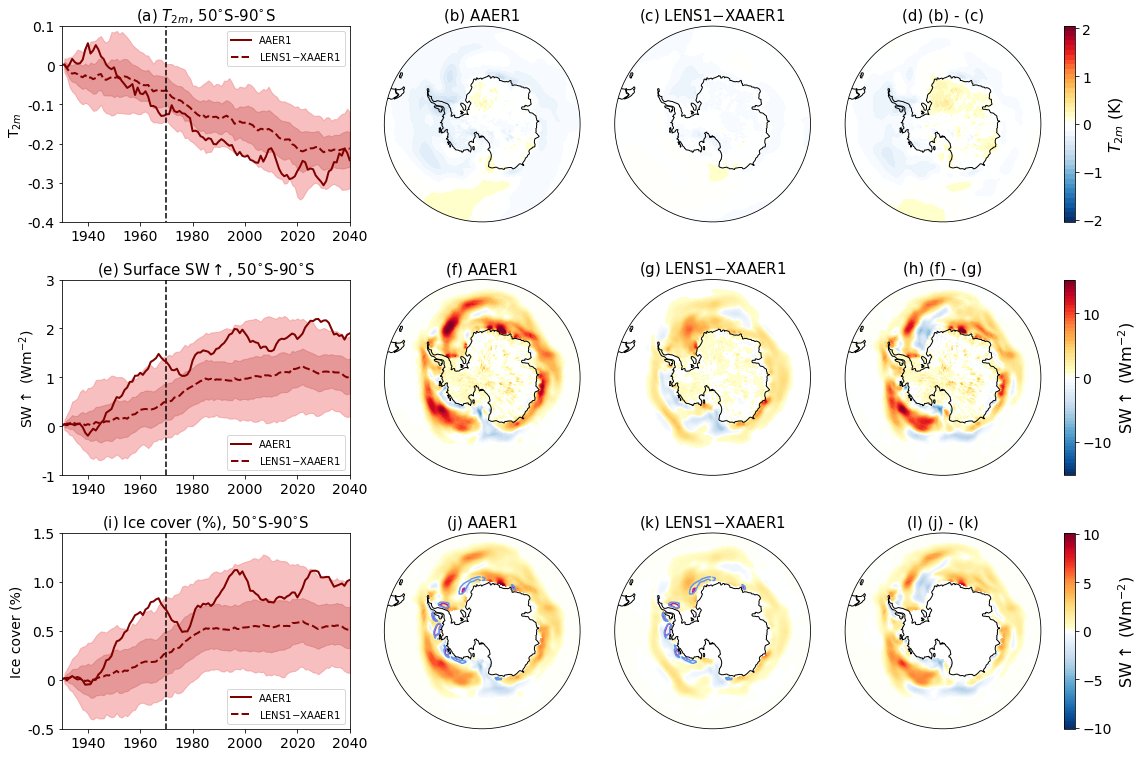

In [20]:
fig = plt.figure(figsize=(16,16))

#------------------TREFHT
ax = fig.add_axes([0.02,0.85,0.25,0.17])
ax.fill_between(cesm1boot.year, cesm1boot.TREFHT_min95_3, cesm1boot.TREFHT_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm1boot.year, cesm1boot.TREFHT_min95, cesm1boot.TREFHT_max95, color='indianred', alpha=0.4)
ax.plot(aer1_nh_21y.year, aer1_nh_21y.TREFHT, color='maroon', linewidth=2, label='AAER1')
ax.plot(aer1xway_nh_21y.year, aer1xway_nh_21y.TREFHT, color='maroon', linewidth=2, linestyle='dashed', label='LENS1$-$XAAER1')
ax.set_ylim(-0.4,0.1)
ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0,0.1])
ax.set_yticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1'], fontsize=14)
ax.set_ylabel('T$_{2m}$', fontsize=14)
ax.set_title('(a) $T_{2m}$, 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-1,0.1], color='black', linestyle='dashed')

ax.legend(loc='upper right')


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1_1960to1980.TREFHT, xaer1.lon, xaer1.lat,0.1,-2,2,'(b) AAER1',
                                                      0.3,0.47,0.85,0.85+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1xway_1960to1980.TREFHT, aer1xway.lon, aer1xway.lat,0.1,-2,2,'(c) LENS1$-$XAAER1',
                                                      0.5,0.67,0.85,0.85+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1_1960to1980.TREFHT - aer1xway_1960to1980.TREFHT, aer1.lon, aer1.lat,
                                                      0.1,-2,2,'(d) (b) - (c)', 
                                                      0.7,0.87,0.85,0.85+0.17, latlim=-50.)

ax = cbars.plotcolorbar(fig, 0.1, -2, 2, '$T_{2m}$ (K)',0.89,0.9,0.85,0.85+0.17,orient='vertical')
#------------------END TREFHT

#------------------FSUS
ax = fig.add_axes([0.02,0.63,0.25,0.17])
ax.set_ylim(-1,3)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['-1','0','1','2','3'], fontsize=14)
ax.set_ylabel('SW$\\uparrow$ (Wm$^{-2}$)', fontsize=14)
ax.set_title('(e) Surface SW$\\uparrow$, 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-1,4.5], color='black', linestyle='dashed')

ax.fill_between(cesm1bootfsus.year, cesm1bootfsus.FSUS_min95_3, cesm1bootfsus.FSUS_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm1bootfsus.year, cesm1bootfsus.FSUS_min95, cesm1bootfsus.FSUS_max95, color='indianred', alpha=0.4)
ax.plot(aer1_nh_21y.year, aer1_nh_21y.FSUS, color='maroon', linewidth=2, label='AAER1')
ax.plot(aer1xway_nh_21y.year, aer1xway_nh_21y.FSUS, color='maroon', linewidth=2, linestyle='dashed', label='LENS1$-$XAAER1')

ax.legend()


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1_1960to1980.FSUS, xaer1.lon, xaer1.lat,0.5,-15,15,'(f) AAER1',
                                                      0.3,0.47,0.63,0.63+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1xway_1960to1980.FSUS, aer1xway.lon, aer1xway.lat,0.2,-15,15,'(g) LENS1$-$XAAER1',
                                                      0.5,0.67,0.63,0.63+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer1_1960to1980.FSUS - aer1xway_1960to1980.FSUS, aer1.lon, aer1.lat,
                                                      0.5,-15,15,'(h) (f) - (g)', 
                                                      0.7,0.87,0.63,0.63+0.17, latlim=-50.)

ax = cbars.plotcolorbar(fig, 0.5, -15, 15, 'SW$\\uparrow$ (Wm$^{-2}$)',0.89,0.9,0.63,0.63+0.17,orient='vertical')
#------------------END FSUS


#-----------------ICEFRAC
ax = fig.add_axes([0.02,0.41,0.25,0.17])
ax.set_ylim(-0.5,1.5)
ax.set_yticks([-0.5,0,0.5,1,1.5])
ax.set_yticklabels(['-0.5','0','0.5','1.0','1.5'], fontsize=14)
ax.set_ylabel('Ice cover (%)', fontsize=14)
ax.set_title('(i) Ice cover (%), 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-0.5,4], color='black', linestyle='dashed')

ax.fill_between(cesm1boot.year, 100.*cesm1boot.ICEFRAC_min95_3, 100.*cesm1boot.ICEFRAC_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm1boot.year, 100.*cesm1boot.ICEFRAC_min95, 100.*cesm1boot.ICEFRAC_max95, color='indianred', alpha=0.4)
ax.plot(aer1_nh_21y.year, 100.*aer1_nh_21y.ICEFRAC, color='maroon', linewidth=2, label='AAER1')
ax.plot(aer1xway_nh_21y.year, 100.*aer1xway_nh_21y.ICEFRAC, color='maroon', linewidth=2, linestyle='dashed', label='LENS1$-$XAAER1')

ax.legend()

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*aer1_1960to1980.ICEFRAC, xaer1.lon, xaer1.lat,0.2,-10,10,'(j) AAER1',
                                                      0.3,0.47,0.41,0.41+0.17, latlim=-50.)
ax.contour(xaer1_1960to1980.lon, xaer1_1960to1980.lat, xaer1_1960to1980.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='mediumvioletred')
ax.contour(aer1base.lon, aer1base.lat, aer1base.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='cornflowerblue')

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*aer1xway_1960to1980.ICEFRAC, aer1xway.lon, aer1xway.lat,0.2,-10,10,'(k) LENS1$-$XAAER1',
                                                      0.5,0.67,0.41,0.41+0.17, latlim=-50.)
ax.contour(xaer1_1960to1980.lon, xaer1_1960to1980.lat, xaer1_1960to1980.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='mediumvioletred')
ax.contour(aer1base.lon, aer1base.lat, aer1base.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='cornflowerblue')


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*(aer1_1960to1980.ICEFRAC - aer1xway_1960to1980.ICEFRAC), aer1.lon, aer1.lat,
                                                      0.2,-10,10,'(l) (j) - (k)', 
                                                      0.7,0.87,0.41,0.41+0.17, latlim=-50.)


ax = cbars.plotcolorbar(fig, 0.2, -10, 10, 'SW$\\uparrow$ (Wm$^{-2}$)',0.89,0.9,0.41,0.41+0.17,orient='vertical')

fig.savefig(plotpath+'figS13.pdf', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS13.png', bbox_inches='tight', facecolor='white')

